In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification, XLNetConfig
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2024-04-03 08:14:39.376883: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 08:14:39.376946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 08:14:39.378763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 08:14:39.386605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
EPOCHS = 30
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_LEN = 128  # Maximum sequence length
NUM_LABELS = 6
base_save_path = "XLNet_v1/checkpoints"
checkpoint_path = "XLNet_v1/checkpoints/cp-{epoch:04d}.ckpt"


# F1 Metric
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [3]:
# Setup and Data Preparation
file_path = "../emotion_data_merged_4.csv"
dataset = pd.read_csv(file_path)
dataset = dataset.dropna(subset=["emotion"]).query("emotion != 'neutral'")
data = dataset.drop_duplicates()
data = data.sample(frac=1).reset_index(drop=True)

# data = data[:1000]

In [4]:
sentences = data["sentence"].values
labels = data["emotion"].values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = tf.convert_to_tensor(labels)
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="tf",
    )
    input_ids.append(encoded_dict["input_ids"])
    attention_masks.append(encoded_dict["attention_mask"])

input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)
input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()
labels_np = labels.numpy()
X_train, X_val, y_train, y_val = train_test_split(
    input_ids_np,
    labels_np,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels_np,
)
train_mask, val_mask = train_test_split(
    attention_masks_np,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels_np,
)
X_train = tf.constant(X_train)
X_val = tf.constant(X_val)
y_train = tf.constant(y_train)
y_val = tf.constant(y_val)
train_mask = tf.constant(train_mask)
val_mask = tf.constant(val_mask)
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        ({"input_ids": X_train, "attention_mask": train_mask}, y_train)
    )
    .shuffle(len(X_train))
    .batch(BATCH_SIZE)
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    ({"input_ids": X_val, "attention_mask": val_mask}, y_val)
).batch(BATCH_SIZE)

2024-04-03 08:14:44.741096: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-03 08:14:44.741472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16440 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [5]:
# Model training
model_config = XLNetConfig.from_pretrained(
    "xlnet-base-cased", num_labels=len(label_encoder.classes_)
)
model = TFXLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased", config=model_config
)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertF

In [6]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy", f1_metric])

early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=3, verbose=1, restore_best_weights=True, mode="max"
)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1)
labels_encoded = label_encoder.fit_transform(labels)
class_counts = np.unique(labels_encoded, return_counts=True)[1]
total_samples = len(labels_encoded)
class_weights = {
    i: total_samples / (count * len(class_counts))
    for i, count in enumerate(class_counts)
}
os.makedirs(base_save_path, exist_ok=True)
checkpoint_path = os.path.join(base_save_path, "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_freq="epoch",
)

In [ ]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler, cp_callback],
    class_weight=class_weights,
)

Epoch 1/30


2024-04-03 08:19:56.647341: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8f580c0c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 08:19:56.647394: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-03 08:19:56.657135: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-03 08:19:56.955059: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1712132397.078662  289847 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5990/5990 [==============================] - ETA: 0s - loss: 0.2313 - accuracy: 0.9175 - f1_metric: 1.1939

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7f98b61f56c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7f98b61f56c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_loss improved from inf to 0.10926, saving model to XLNet_v1/checkpoints/cp-0001.ckpt
5990/5990 [==============================] - 4841s 800ms/step - loss: 0.2313 - accuracy: 0.9175 - f1_metric: 1.1939 - val_loss: 0.1093 - val_accuracy: 0.9615 - val_f1_metric: 0.9992 - lr: 1.0000e-05
Epoch 2/30
5990/5990 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9634 - f1_metric: 1.0688
Epoch 2: val_loss improved f

In [17]:
results = model.evaluate(val_dataset)
print(
    f"Validation loss: {results[0]}, Validation accuracy: {results[1]}, Validation F1 Score: {results[2]}"
)

2024-04-04 09:26:12.645417: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 48.00MiB (rounded to 50331648)requested by op tfxl_net_for_sequence_classification/transformer/layer_._11/rel_attn/einsum_3/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-04 09:26:12.645572: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-04-04 09:26:12.645588: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 91, Chunks in use: 91. 22.8KiB allocated for chunks. 22.8KiB in use in bin. 721B client-requested in use in bin.
2024-04-04 09:26:12.645596: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 100, Chunks in use: 100. 74.8KiB allocated for chunks. 74.8KiB i

ResourceExhaustedError: Graph execution error:

Detected at node tfxl_net_for_sequence_classification/transformer/layer_._11/rel_attn/einsum_3/Einsum defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_289183/3911223970.py", line 1, in <module>

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1170, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1856, in fit

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1195, in evaluate

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1720, in test_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1441, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 1455, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1441, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 778, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 785, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 403, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 214, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 312, in call

OOM when allocating tensor with shape[16384,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tfxl_net_for_sequence_classification/transformer/layer_._11/rel_attn/einsum_3/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_1499271]

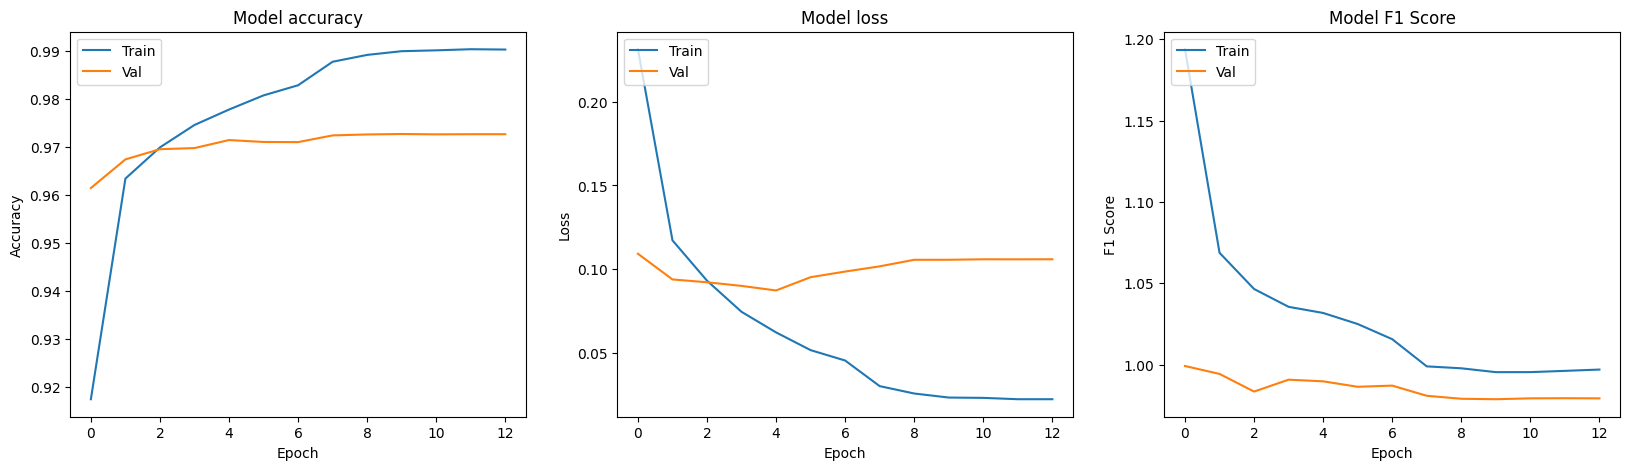

In [13]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    # Plot training & validation accuracy values
    ax[0].plot(history.history["accuracy"])
    ax[0].plot(history.history["val_accuracy"])
    ax[0].set_title("Model accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Val"], loc="upper left")

    # Plot training & validation loss values
    ax[1].plot(history.history["loss"])
    ax[1].plot(history.history["val_loss"])
    ax[1].set_title("Model loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Val"], loc="upper left")

    # Plot training & validation F1 score values
    ax[2].plot(history.history["f1_metric"])
    ax[2].plot(history.history["val_f1_metric"])
    ax[2].set_title("Model F1 Score")
    ax[2].set_ylabel("F1 Score")
    ax[2].set_xlabel("Epoch")
    ax[2].legend(["Train", "Val"], loc="upper left")

    plt.show()


plot_training_history(history)

In [36]:
# Assuming X_val and y_val are your test inputs and labels, respectively.
# If you have a separate test set, replace X_val and y_val accordingly.

# Predict classes with the model
predictions = model.predict({"input_ids": X_val, "attention_mask": val_mask})
predicted_labels = np.argmax(predictions.logits, axis=1)

# Since your labels are already encoded with LabelEncoder, there's no need to decode them

# Generate the confusion matrix
cm = confusion_matrix(y_val, predicted_labels)

# Calculate per-class accuracies
accuracies = cm.diagonal() / cm.sum(axis=1)

# Create an annotated confusion matrix with accuracies
cm_with_acc = cm.astype("str")  # Convert counts to string for annotation
for i in range(len(cm)):
    for j in range(len(cm[i])):
        # Append accuracy to the diagonal elements
        if i == j:
            cm_with_acc[i][j] = f"{cm[i][j]}\n({accuracies[i]*100:.1f}%)"
        else:
            cm_with_acc[i][j] += "\n "

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=cm_with_acc,
    fmt="",
    ax=ax,
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix with Accuracies")
plt.show()

2024-04-04 13:25:44.307902: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 48.00MiB (rounded to 50331648)requested by op tfxl_net_for_sequence_classification/transformer/layer_._0/rel_attn/einsum_5/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-04 13:25:44.308067: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-04-04 13:25:44.308093: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 88, Chunks in use: 88. 22.0KiB allocated for chunks. 22.0KiB in use in bin. 457B client-requested in use in bin.
2024-04-04 13:25:44.308105: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 99, Chunks in use: 99. 74.2KiB allocated for chunks. 74.2KiB in u

ResourceExhaustedError: Graph execution error:

Detected at node tfxl_net_for_sequence_classification/transformer/layer_._0/rel_attn/einsum_5/Einsum defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_289183/2004568263.py", line 5, in <module>

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1190, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1441, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 1455, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1441, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 778, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 785, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 403, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 214, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 315, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 151, in rel_attn_core

OOM when allocating tensor with shape[32,12,128,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tfxl_net_for_sequence_classification/transformer/layer_._0/rel_attn/einsum_5/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_1983564]

In [37]:
# Load the test dataset
test_df = pd.read_csv("../test_group.csv", sep="\t")

# Replace the exclamation point at the end of each sentence with a dot
test_df["sentence"] = test_df["sentence"].str.replace(r"!\s*$", ".", regex=True)

# Assuming 'sentence' is your column of interest and tokenizer is already defined
# Prepare the test sentences with RobertaTokenizer
test_input_ids = []
test_attention_masks = []

for sent in test_df["sentence"]:
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=128,  # Pad & truncate all sentences
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attention masks
        return_tensors="tf",  # Return tf tensors
    )

    # Add the encoded sentence to the list
    test_input_ids.append(encoded_dict["input_ids"])
    test_attention_masks.append(encoded_dict["attention_mask"])

# Convert lists into tensors
test_input_ids = tf.concat(test_input_ids, axis=0)
test_attention_masks = tf.concat(test_attention_masks, axis=0)

# Make predictions using the trained model
predictions = model.predict(
    {"input_ids": test_input_ids, "attention_mask": test_attention_masks}
)
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert numeric predictions back to original labels using the LabelEncoder
predicted_emotions = label_encoder.inverse_transform(predicted_labels)

# Prepare the submission DataFrame
submission_df = pd.DataFrame(
    {
        "id": test_df["id"],  # Assuming there's an 'id' column in your test set
        "emotion": predicted_emotions,
    }
)

# Define the mapping from integer labels to emotion names
emotion_mapping = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happiness",
    4: "sadness",
    5: "surprise",
}

# Apply the mapping to the 'emotion' column
submission_df["emotion"] = submission_df["emotion"].map(emotion_mapping)

# Save the submission file
submission_df.to_csv("XLNet_V1_predictions.csv", index=False, sep=",")

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  self.deprecation_warnings["Asking-to-pad-to-max_length"] = True
2024-04-05 17:58:20.547851: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 48.00MiB (rounded to 50331648)requested by op tfxl_net_for_sequence_classification/transformer/layer_._0/rel_attn/einsum_5/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocat

ResourceExhaustedError: Graph execution error:

Detected at node tfxl_net_for_sequence_classification/transformer/layer_._0/rel_attn/einsum_5/Einsum defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_289183/2004568263.py", line 5, in <module>

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1190, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1441, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 1455, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1441, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 778, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 785, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 403, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 214, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 315, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 151, in rel_attn_core

OOM when allocating tensor with shape[32,12,128,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tfxl_net_for_sequence_classification/transformer/layer_._0/rel_attn/einsum_5/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_1983564]

In [16]:
import joblib

# Define the base path for saving
base_save_path = "XLNet_v1"

# Specify the paths for the model, tokenizer, and label encoder
model_save_path = f"{base_save_path}/model"
tokenizer_save_path = f"{base_save_path}/tokenizer"
label_encoder_save_path = f"{base_save_path}/label_encoder.joblib"

# Assuming `model` is your TFRobertaForSequenceClassification model,
# `tokenizer` is your RobertaTokenizer, and `label_encoder` is your LabelEncoder instance

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

# Save the label encoder
joblib.dump(label_encoder, label_encoder_save_path)

['XLNet_v1/label_encoder.joblib']

In [23]:
print("Done")

Done
